# Super Res Model Inference

In [1]:
from torch import nn
import torch

### The model components

In [4]:
def conv_layer(in_,out_,ks, stride,activation = True):
    layers = [
        nn.Conv2d(in_,out_,kernel_size = ks, stride = stride, padding = ks//2, bias = False),
        nn.BatchNorm2d(out_),
    ]
    if activation: layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

class res_block(nn.Module):
    def __init__(self,nb_filter):
        """
        simple resnet block
        """
        super(res_block,self).__init__()
        self.nb_filter = nb_filter
        self.clayer1 = conv_layer(self.nb_filter,self.nb_filter,3,(1,1))
        self.clayer2 = conv_layer(self.nb_filter,self.nb_filter,3,(1,1),activation = False)
    
    def forward(self,x):
        x2 = self.clayer2(self.clayer1(x))
        return x2+x
    
def up_block(nb_filters):
    layers = [nn.Upsample(scale_factor=2),
                conv_layer(nb_filters,nb_filters,3,stride = (1,1),activation=True),
             ]
    return nn.Sequential(*layers)

### The Model

In [48]:
class small2big(nn.Module):
    def __init__(self,nb_filters=64):
        super(small2big,self).__init__()
        self.nb_filters = nb_filters
        self.input_conv = conv_layer(in_=3,out_=self.nb_filters,ks=9,stride=1)
        self.res_blocks = nn.Sequential(*list(res_block(self.nb_filters) for i in range(6)))
        self.up = nn.Sequential(*list(up_block(self.nb_filters) for i in range(1)))
        self.output_conv = nn.Sequential(*[
            nn.Conv2d(in_channels=self.nb_filters,out_channels=3,kernel_size=5,stride=(1,1),padding = 2),
            nn.Sigmoid(),
                                          ])
        
    def forward(self,x):
        x = self.input_conv(x)
        x = self.res_blocks(x)
        x = self.up(x)
        x = self.output_conv(x)
        return x
    
def load_model(model,path):
    model.load_state_dict(torch.load(path))

In [55]:
model = small2big()
load_model(model, "super_res_0.0.1.npy")

In [56]:
from torchvision import transforms
from PIL import Image
totensor = transforms.ToTensor()
toimg = transforms.ToPILImage()

In [61]:
def super_pic(path):
    img = Image.open(path).resize((160,120))
    tensor = totensor(img).unsqueeze(0)
    s_img = toimg(model(tensor)[0])
    return img,s_img

In [62]:
img,s_img=super_pic("/data/unlabeled2017/000000001032.jpg")

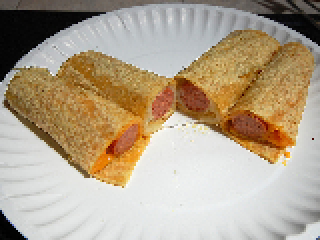

In [63]:
img.resize((img.width*2,img.height*2))

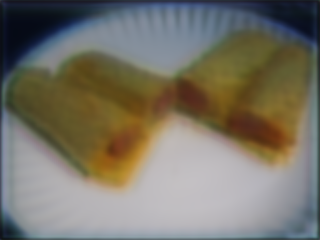

In [64]:
s_img